In [4]:
! pip install chess PyGithub

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.9/349.9 kB 5.2 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for pyjwt[crypto]>=2.4.0 from https://files.pythonhosted.org/packages/2b/4f/e04a8067c7c96c364cef7ef73906504e2f40d690811c021e1a1901473a19/PyJWT-2.8.0-py3-none-any.whl.metadata
  Obtaining dependency information for Deprecated from https://files.pythonhosted.org/packages/20/8d/778b7d51b981a96554f29136cd59ca7880bf58094338085bcf2a979a0e6a/Deprecated-1.2.14-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 10.9 MB/s eta 0:00:00
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to

#### Chess GMs that I want to analyze:
- Mamedyarov
- Radjabov
- Nakamura
- Magnus
- Caruana
- Ding
- Nepomniachtchi
- Anand
- Giri
- Gashimov
- Kramnik

## Part 1: get and prepare data

### Import necessary libraries

In [1]:
import os
import pandas as pd
import chess.pgn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Define function: parsing PGN file and creating dataframe 

In [2]:
def parse_pgn_file(file_path):
    """
    Parses a PGN (Portable Game Notation) file containing chess games.
    
    Args:
        file_path (str): Path to the PGN file.
        
    Returns:
        pd.DataFrame: A DataFrame containing game information.
    """
    games = []  # Initialize an empty list to store parsed games.
    with open(file_path, "r") as pgn_file:
        while True:
            game = chess.pgn.read_game(pgn_file)  # Read a game from the PGN file.
            if game is None:
                break  # Exit the loop when no more games are found.
            games.append(game)  # Append the parsed game to the list.
            
    data = []  # Initialize an empty list to store game data.
    for game in games:
        data.append({
            "Event": game.headers.get("Event", ""),
            "Date": game.headers.get("Date", ""),
            "Result": game.headers.get("Result", ""),
            "White": game.headers.get("White", ""),
            "Black": game.headers.get("Black", ""),
            "Moves": " ".join(str(move) for move in game.mainline_moves()),
            "ECO": game.headers.get("ECO", "")
        })  # Extract relevant information from game headers and moves.
    
    df = pd.DataFrame(data)  # Create a DataFrame from the extracted data.
    return df  # Return the DataFrame containing game information.


### Getting data from directory and combining to full dataset

In [3]:
# Set the path to the directory containing PGN files
path = "GM_data/"

# Initialize an empty DataFrame to store the combined data
df_full = pd.DataFrame()

# Iterate through each file in the directory
for GM in os.listdir(path):
    # Skip files that are not PGN files
    if ".pgn" not in GM:
        continue
    
    # Extract the GM name from the file name
    GM_name = GM.split(".")[0]
    
    # Parse the PGN file and create a temporary DataFrame
    df_temp = parse_pgn_file(path + GM)
    
    # Add a new column to store the GM name
    df_temp['GM_name'] = GM_name
    
    # Concatenate the temporary DataFrame with the full DataFrame
    df_full = pd.concat([df_temp, df_full])
    
    # Print the number of games for each GM
    print(GM_name + " has " + str(df_temp.shape[0]) + " games")

# Remove rows where the ECO column is empty (for data quality purposes)
df_full = df_full[df_full.ECO != '']

# Print the total number of games and unique ECO codes
print("\nWe have " + str(len(df_full.ECO.unique())) + " unique ECO codes that these players have played")
print("\nWe have " + str(df_full.shape[0]) + " games in total")

Kramnik has 3610 games
Nakamura has 6603 games
Caruana has 4114 games
Giri has 3312 games
Mamedyarov has 4420 games
Gashimov has 953 games
Carlsen has 5000 games
Nepomniachtchi has 3410 games
Radjabov has 2339 games
Ding has 2011 games
Anand has 4084 games
We have 39820 games in total


In [4]:
df_full.sample(5)

,Event,Date,Result,White,Black,Moves,ECO,GM_name
2369,7th Sinquefield Cup 2019,2019.08.24,1/2-1/2,"Giri,A","Caruana,F",d2d4 g8f6 c2c4 e7e6 g1f3 d7d5 b1c3 f8e7 c1f4 e...,D37,Caruana
1348,SuperGM,2000.02.28,1/2-1/2,"Leko,P","Anand,V",e2e4 c7c6 d2d4 d7d5 b1c3 d5e4 c3e4 b8d7 e4g5 g...,B17,Anand
2589,World Rapid 2018,2018.12.28,0-1,"Salem,AR","Mamedyarov,S",e2e4 e7e5 g1f3 b8c6 f1b5 a7a6 b5a4 g8f6 d2d3 b...,C77,Mamedyarov
2041,Tal Memorial,2010.11.12,1/2-1/2,"Kramnik,V","Mamedyarov,S",d2d4 g8f6 c2c4 g7g6 b1c3 d7d5 c4d5 f6d5 e2e4 d...,D85,Kramnik
3037,Aimchess Rapid Prelim,2022.10.16,1/2-1/2,"Giri,A","Naroditsky,D",e2e4 c7c6 g1f3 d7d5 d2d3 d8c7 e4d5 c6d5 c2c4 g...,B10,Giri


In [108]:
# Let's group dataframe by GM name and count unique number of ECOs
ECO_unique = df_full.groupby(by='GM_name').agg(ECO_unique_count = ('ECO', pd.Series.nunique)).sort_values(by='ECO_unique_count', ascending=False)
ECO_unique

,ECO_unique_count
GM_name,
Nakamura,391
Carlsen,387
Anand,363
Caruana,351
Mamedyarov,344
Kramnik,335
Giri,324
Radjabov,315
Nepomniachtchi,293


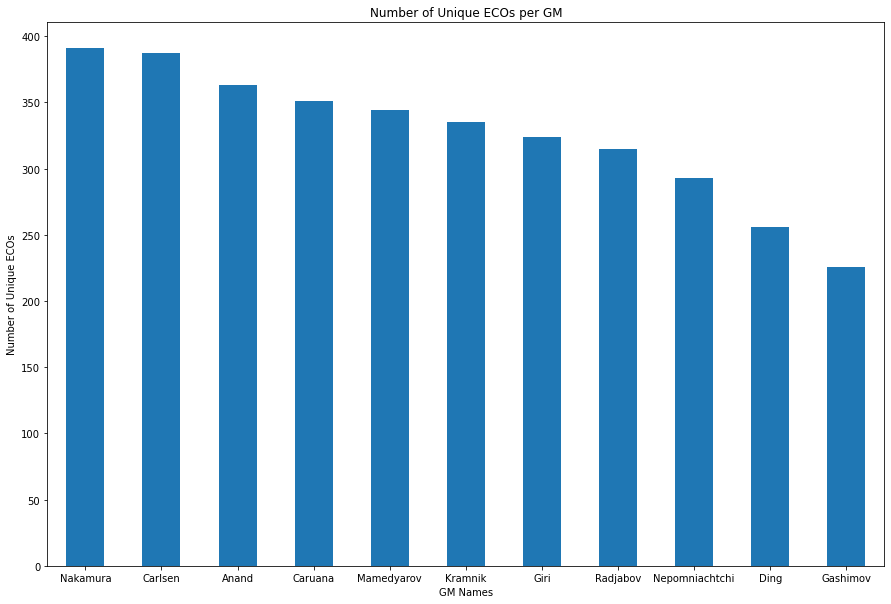

In [109]:
# bar plot for ECO unique dataframe
ax = ECO_unique.plot(kind='bar', rot=0, ylabel='Number of Unique ECOs', xlabel='GM Names', legend=False)
ax.set_title('Number of Unique ECOs per GM')
plt.gcf().set_size_inches(15, 10)

# Show the plot
plt.show()

## Part 2: Feature Engineering

In [5]:
# Get the unique ECO codes in the DataFrame
list_of_ECOs = df_full.ECO.unique()

# Print the number of unique ECO codes
print("We have " + str(len(list_of_ECOs)) + " unique ECO codes")

# Create a pivot table with GM names as rows, ECO codes as columns, and count of events as values
pivot_table = pd.pivot_table(df_full, index='GM_name', columns='ECO', values='Event', aggfunc='count')

# Fill missing values (NaN) with zeros
pivot_table = pivot_table.fillna(0)

# Convert the pivot table values to integers
pivot_table = pivot_table.astype(int)

# Calculate the total number of games played by each GM
total_games = df_full.groupby(by='GM_name')['ECO'].count()

# Calculate the proportion of games played for each ECO code by each GM
# not rounding to smaller decimals, as then the row sum is not 1
proportion = pivot_table.div(total_games, axis=0)

We have 484 unique ECO codes


In [13]:
pivot_table

ECO,A00,A01,A02,A03,A04,A05,A06,A07,A08,A09,...,E90,E91,E92,E93,E94,E95,E96,E97,E98,E99
GM_name,,,,,,,,,,,,,,,,,,,,,
Anand,2,9,0,0,14,12,14,37,17,14,...,6,2,0,1,7,0,0,8,0,1
Carlsen,108,62,4,5,52,54,16,70,5,6,...,11,2,10,1,20,0,0,8,2,0
Caruana,32,26,0,4,38,62,42,59,16,15,...,1,0,3,0,7,0,0,1,0,0
Ding,1,6,0,0,12,21,14,57,6,4,...,14,6,8,0,14,0,0,16,2,3
Gashimov,0,1,1,0,10,0,0,1,1,1,...,1,0,0,0,0,0,0,0,0,0
Giri,12,15,3,2,26,34,34,62,13,7,...,6,9,5,2,16,0,0,12,4,2
Kramnik,6,16,0,3,61,55,7,81,7,12,...,5,10,15,3,16,0,1,36,0,0
Mamedyarov,30,37,1,1,23,44,23,31,3,1,...,1,8,2,0,7,0,0,1,0,0
Nakamura,164,128,10,12,143,358,308,144,25,9,...,15,11,21,0,18,0,1,31,6,5


In [14]:
proportion

ECO,A00,A01,A02,A03,A04,A05,A06,A07,A08,A09,...,E90,E91,E92,E93,E94,E95,E96,E97,E98,E99
GM_name,,,,,,,,,,,,,,,,,,,,,
Anand,0.000490,0.002205,0.000000,0.000000,0.003430,0.002940,0.003430,0.009064,0.004165,0.003430,...,0.001470,0.000490,0.000000,0.000245,0.001715,0.000000,0.000000,0.001960,0.000000,0.000245
Carlsen,0.021617,0.012410,0.000801,0.001001,0.010408,0.010809,0.003203,0.014011,0.001001,0.001201,...,0.002202,0.000400,0.002002,0.000200,0.004003,0.000000,0.000000,0.001601,0.000400,0.000000
Caruana,0.007782,0.006323,0.000000,0.000973,0.009241,0.015078,0.010214,0.014348,0.003891,0.003648,...,0.000243,0.000000,0.000730,0.000000,0.001702,0.000000,0.000000,0.000243,0.000000,0.000000
Ding,0.000498,0.002987,0.000000,0.000000,0.005973,0.010453,0.006969,0.028372,0.002987,0.001991,...,0.006969,0.002987,0.003982,0.000000,0.006969,0.000000,0.000000,0.007964,0.000996,0.001493
Gashimov,0.000000,0.001049,0.001049,0.000000,0.010493,0.000000,0.000000,0.001049,0.001049,0.001049,...,0.001049,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Giri,0.003628,0.004534,0.000907,0.000605,0.007860,0.010278,0.010278,0.018742,0.003930,0.002116,...,0.001814,0.002721,0.001511,0.000605,0.004837,0.000000,0.000000,0.003628,0.001209,0.000605
Kramnik,0.001662,0.004432,0.000000,0.000831,0.016898,0.015235,0.001939,0.022438,0.001939,0.003324,...,0.001385,0.002770,0.004155,0.000831,0.004432,0.000000,0.000277,0.009972,0.000000,0.000000
Mamedyarov,0.006815,0.008405,0.000227,0.000227,0.005225,0.009995,0.005225,0.007042,0.000682,0.000227,...,0.000227,0.001817,0.000454,0.000000,0.001590,0.000000,0.000000,0.000227,0.000000,0.000000
Nakamura,0.024845,0.019391,0.001515,0.001818,0.021663,0.054234,0.046660,0.021815,0.003787,0.001363,...,0.002272,0.001666,0.003181,0.000000,0.002727,0.000000,0.000151,0.004696,0.000909,0.000757


In [15]:
pivot_table.idxmax(axis=1)

GM_name
Anand             B90
Carlsen           D37
Caruana           C65
Ding              E60
Gashimov          C42
Giri              B90
Kramnik           C42
Mamedyarov        D37
Nakamura          A05
Nepomniachtchi    B90
Radjabov          D37
dtype: object

We can already see what is the most favorite opening for each GM:

- B90 - Sicilian Defense, Najdorf variation : Anand, Giri, Nepomniachtchi
- D37 - Queen's Gambit Declined : Carlsen, Mamedyarov, Radjabov
- C42 - Russian Game : Gashimov, Kramnik
- A05 - King's Indian Attack : Nakamura
- C65 - Spanish Game, Berlin Defense : Caruana
- E60 - Gruenfeld and Indian Game : Ding

Let's see what we get from clustering, which will be more precise, taking into account other favorite openings in rank too

### Visualization of ECO proportion distrubution for each GM

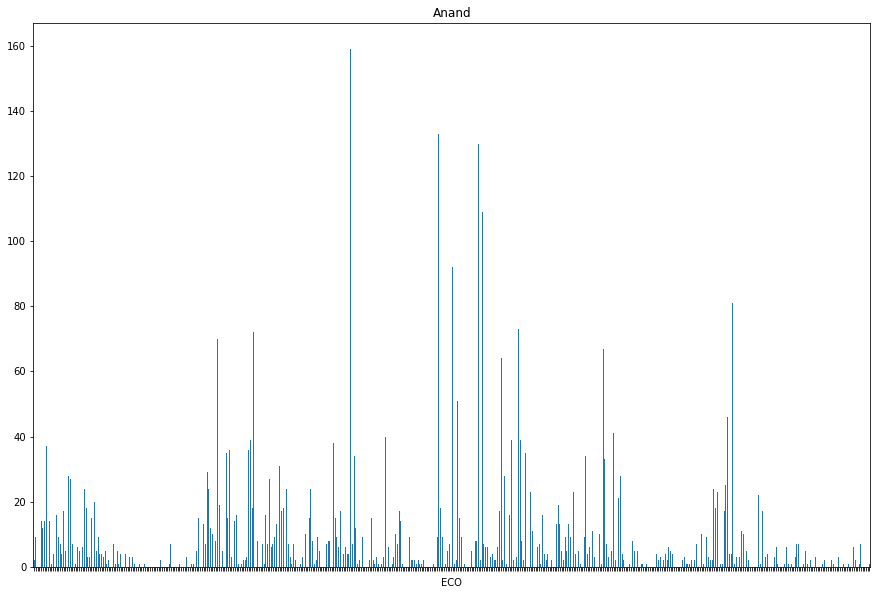

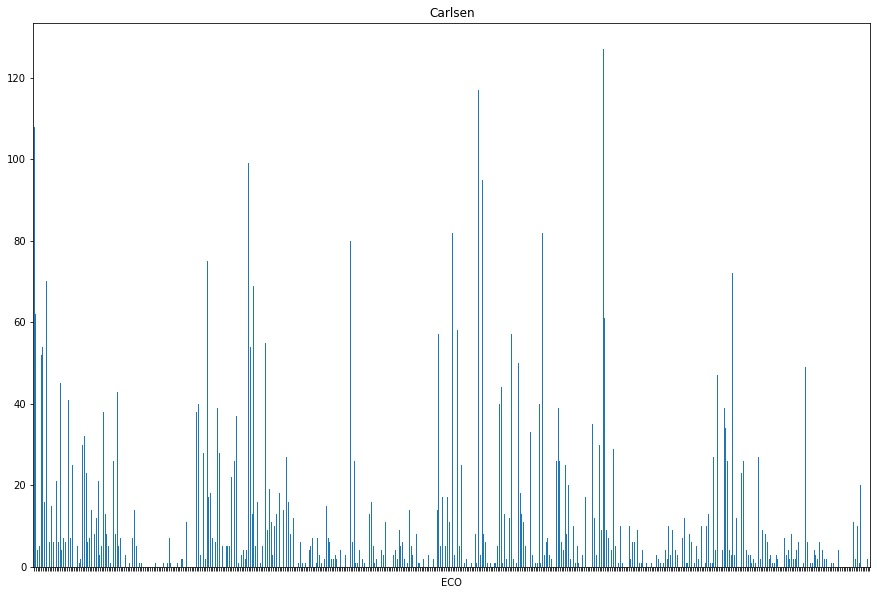

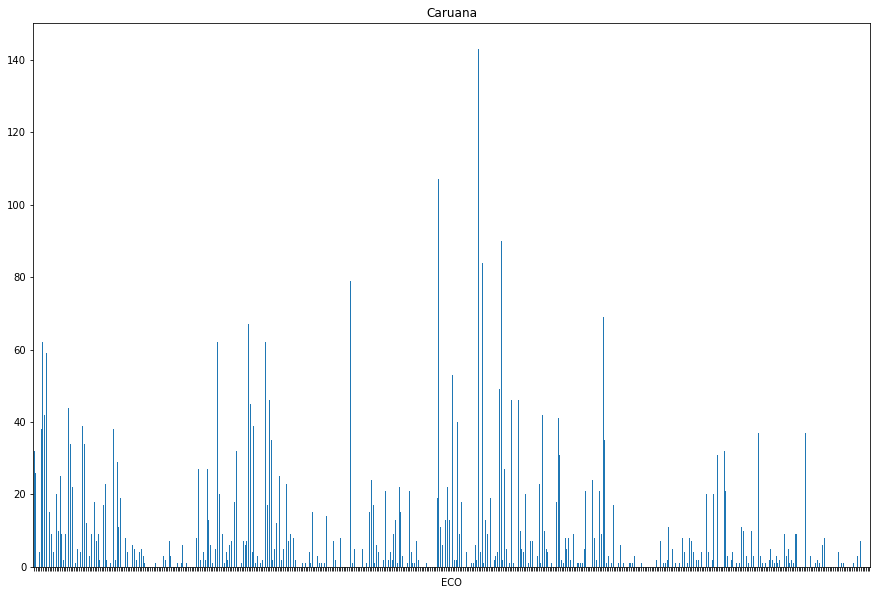

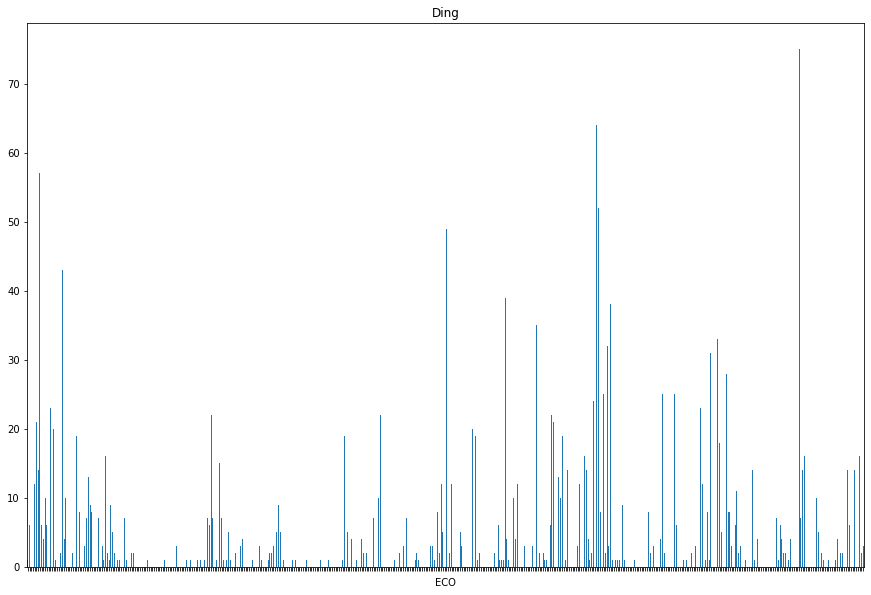

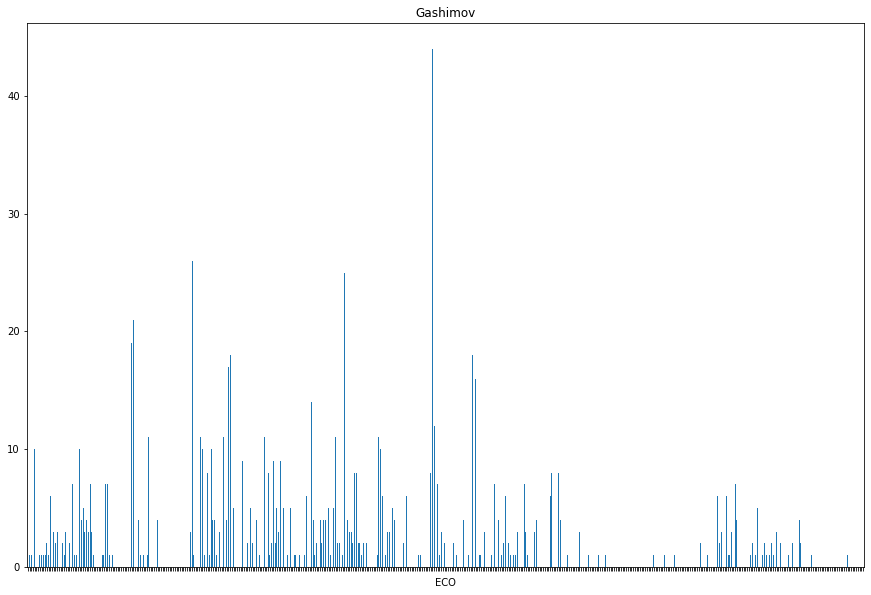

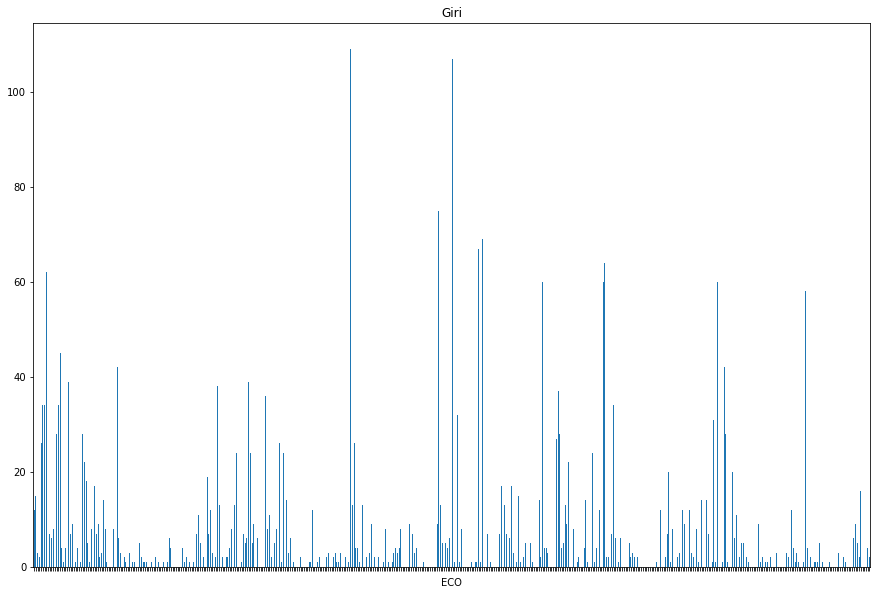

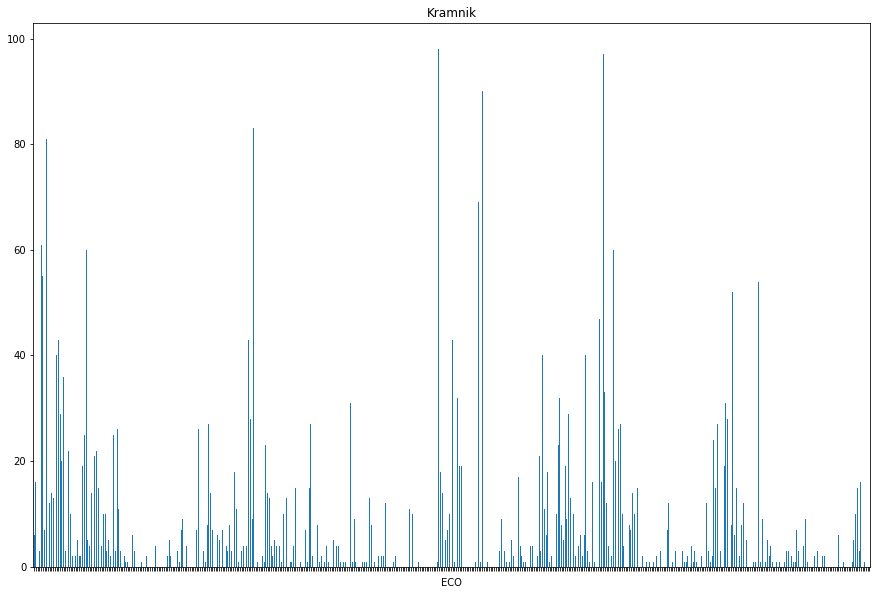

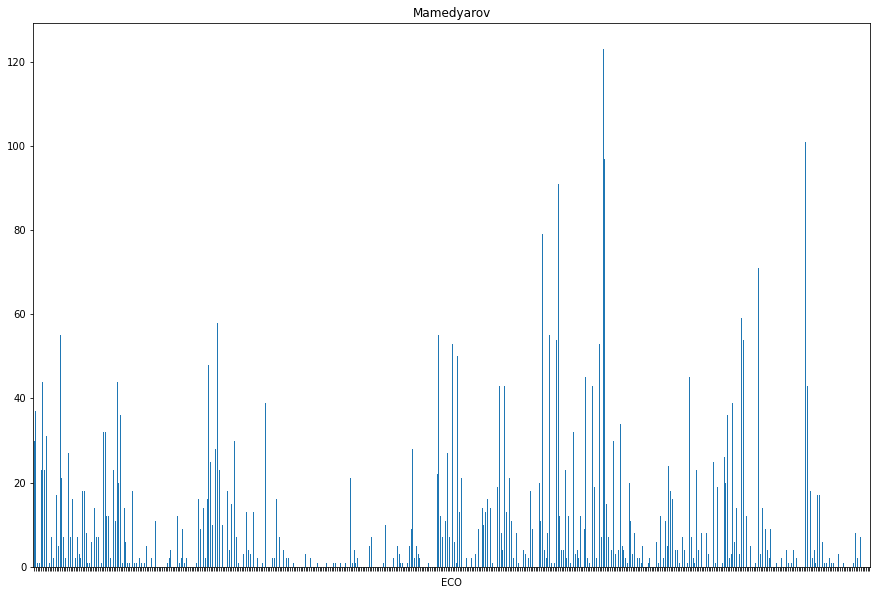

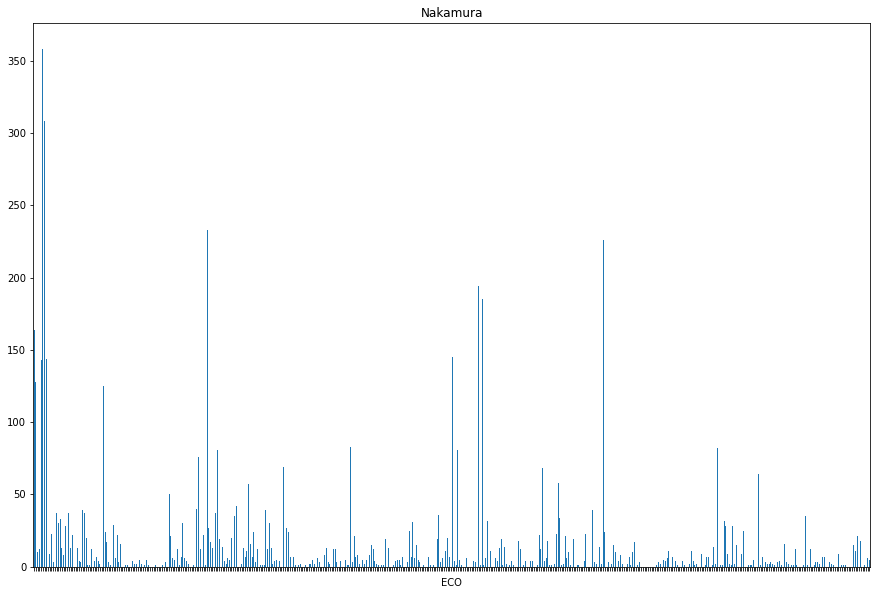

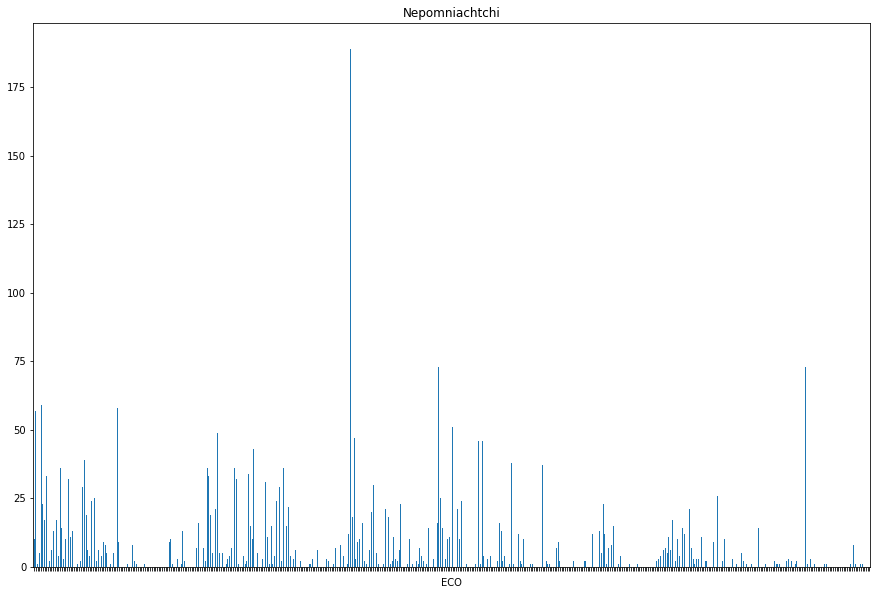

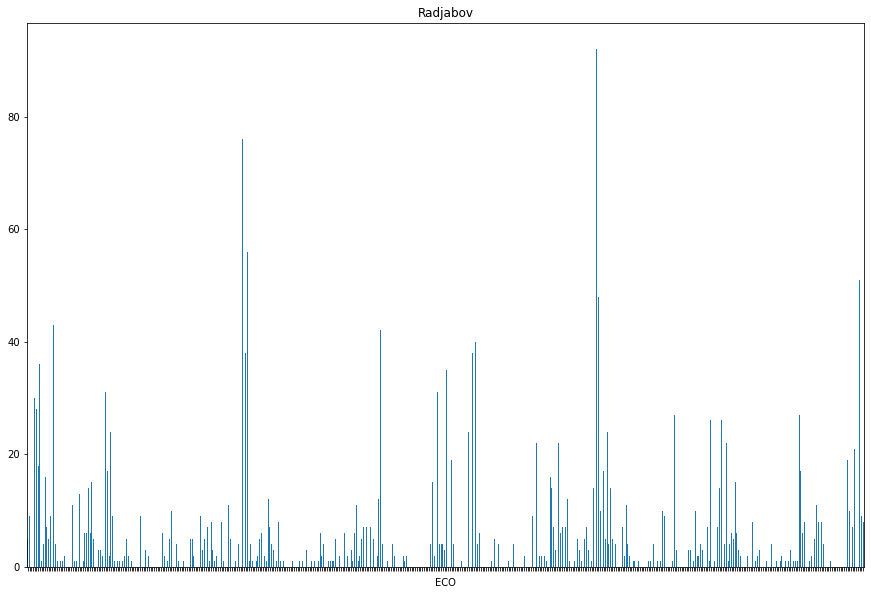

In [6]:
# Iterate through each name in the index of the pivot table
for name in pivot_table.index:
    # Create a bar plot with stacked bars
    ax = pivot_table.loc[name].plot(kind='bar', stacked=True)
    
    # Remove x-axis tick labels as they are too huge
    ax.set_xticklabels('')
    
    # Set the title of the plot to the GM name
    plt.title(name)
    
    # Adjust the size of the figure
    plt.gcf().set_size_inches(15, 10)
    
    # Display the plot
    plt.show()

#### key takeaway from these graphs is that they all have enormous number of openings prepataion in their arsenal, but still majority of them have around 5 favorite openings, which they play significantly more often than other openings

### Get top 5 openings for each GM

In [10]:
# Calculate the top 5 eco codes for each row in the pivot table
top_5_eco_codes = pivot_table.apply(lambda x: x.sort_values(ascending=False).head(5), axis=1)

# Normalize the values by dividing each row by itself (essentially setting all values to 1)
top_5_eco_codes = top_5_eco_codes / top_5_eco_codes

# Create a DataFrame from the top 5 eco codes
top5_df = pd.DataFrame(top_5_eco_codes)

# Fill any missing values with 0
top5_df = top5_df.fillna(0)

# Convert the pivot table values to integers
top5_df = top5_df.astype(int)

# Filter out columns where all values are 0
top5_df = top5_df.loc[:, (top5_df != 0).any(axis=0)]

In [11]:
# Calculate the top 5 eco code indices for each row in the pivot table
pivot_table.apply(lambda x: x.sort_values(ascending=False).head(5).index.to_list(), axis=1)

GM_name
Anand             [B90, C42, C65, C67, C50]
Carlsen           [D37, C65, A00, B30, C67]
Caruana           [C65, C42, C78, C67, B90]
Ding              [E60, D37, A07, D38, C50]
Gashimov          [C42, B01, B90, A61, A60]
Giri              [B90, C50, C42, C67, C65]
Kramnik           [C42, D37, C67, B33, A07]
Mamedyarov        [D37, E60, D38, D11, A45]
Nakamura          [A05, A06, B06, D37, C65]
Nepomniachtchi    [B90, D85, C45, E60, C42]
Radjabov          [D37, B30, B33, E97, D38]
dtype: object

In [12]:
top5_df

ECO,A00,A05,A06,A07,A45,A60,A61,B01,B06,B30,...,C50,C65,C67,C78,D11,D37,D38,D85,E60,E97
GM_name,,,,,,,,,,,,,,,,,,,,,
Anand,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
Carlsen,1,0,0,0,0,0,0,0,0,1,...,0,1,1,0,0,1,0,0,0,0
Caruana,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,0
Ding,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,1,0
Gashimov,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Giri,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
Kramnik,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
Mamedyarov,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,1,1,0,1,0
Nakamura,0,1,1,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0


## Part 3: Clustering

### find best number of principal components

In [17]:
# Iterate over different numbers of components for PCA
for j in range(1, 12):
    # Initialize PCA with j components
    pca = PCA(n_components=j)
    # Transform the data using PCA
    principal_components = pca.fit_transform(top5_df)

    # Initialize KMeans clustering with 4 clusters
    kmeans = KMeans(n_clusters=4, random_state=0)
    # Fit KMeans to the transformed data
    kmeans.fit(principal_components)

    # Calculate silhouette score
    silhouette = silhouette_score(principal_components, kmeans.labels_)

    # Print evaluation metrics
    print(f'Silhouette Score: {silhouette:.2f} for {j} number of components')

Silhouette Score: 0.78 for 1 number of components
Silhouette Score: 0.69 for 2 number of components
Silhouette Score: 0.55 for 3 number of components
Silhouette Score: 0.43 for 4 number of components
Silhouette Score: 0.31 for 5 number of components
Silhouette Score: 0.26 for 6 number of components
Silhouette Score: 0.21 for 7 number of components
Silhouette Score: 0.18 for 8 number of components
Silhouette Score: 0.13 for 9 number of components
Silhouette Score: 0.13 for 10 number of components
Silhouette Score: 0.13 for 11 number of components


#### it is visible that even one principal component can explain the majority of the variance of the data. 
#### but as end results of 1 and 2 principal components are the same and it is easier to visualize 2 principal components, I will pick that.

### Try 1

#### I will use Proportion data in this try

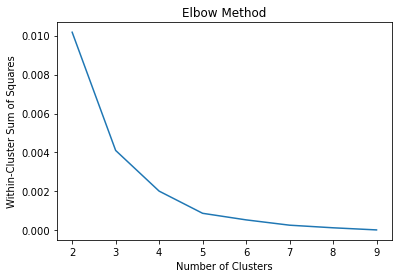

In [18]:
# Initialize PCA with 2 components
pca = PCA(n_components=2)
# Transform the data using PCA
principal_components = pca.fit_transform(proportion)

# Initialize an empty list to store Within-Cluster Sum of Squares (WCSS)
wcss = []
# Iterate over different numbers of clusters
for i in range(2, 10):
    # Initialize KMeans clustering with i clusters
    kmeans = KMeans(n_clusters=i)
    # Fit KMeans to the transformed data
    kmeans.fit(principal_components)
    # Calculate and store the WCSS
    wcss.append(kmeans.inertia_)

# Plot the results using the Elbow Method
plt.plot(range(2, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.show()

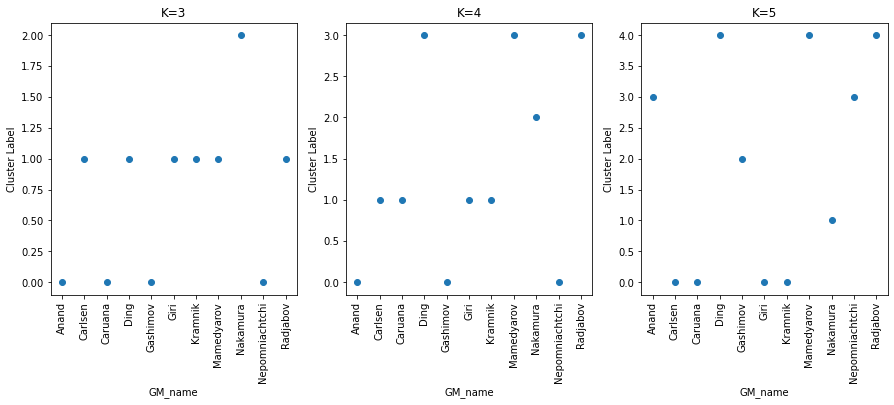

In [390]:
# Initialize a list of k values for KMeans clustering
k_values = [3, 4, 5]
results = []

# Iterate over each k value
for k in k_values:
    # Initialize KMeans clustering with k clusters
    kmeans = KMeans(n_clusters=k)
    # Fit KMeans to the principal components
    kmeans.fit(principal_components)
    # Append the cluster labels to the results list
    results.append(kmeans.labels_)

# Create subplots for each k value
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, k in enumerate(k_values):
    # Scatter plot of GM_name vs. cluster labels
    axs[i].scatter(proportion.index, results[i])
    axs[i].set_title(f'K={k}')
    axs[i].set_xlabel('GM_name')
    axs[i].set_ylabel('Cluster Label')
    axs[i].tick_params(axis='x', labelrotation=90)

# Show the plot
plt.show()

#### elbow method shows all three options are good: 3, 4, 5. But as per visualization, it groups 6 GMs out of 11 into one group, which is not the best, so, I will choose 4 clusters 

In [26]:
# Create the clustering model using KMeans algorithm
kmeans = KMeans(n_clusters=4)
kmeans.fit(principal_components)

# Calculate the silhouette score
silhouette = silhouette_score(principal_components, kmeans.labels_)

# Print the silhouette score with two decimal places
print(f'Silhouette Score: {silhouette:.2f}')

Silhouette Score: 0.41


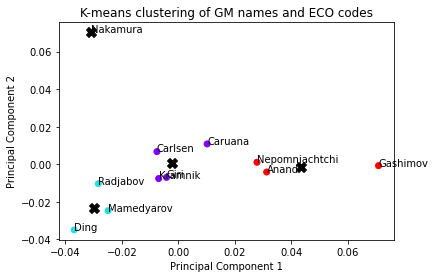

In [25]:
# Visualize the data and centroids in two-dimensional space
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', marker='X')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means clustering of GM names and ECO codes')

# Add GM names to the graph
for i, txt in enumerate(proportion.index):
    plt.annotate(txt, (principal_components[i, 0], principal_components[i, 1]))

plt.show()

#### Nakamura seems to be clear Outlier in this method

### Try 2

#### I will use top5_df data in this try

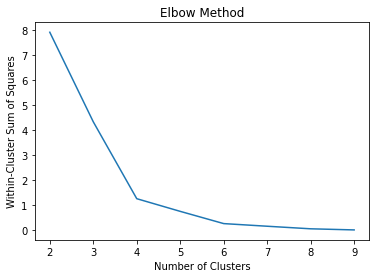

In [28]:
# Perform Principal Component Analysis (PCA) with 2 component
pca = PCA(n_components=2)
principal_components = pca.fit_transform(top5_df)

# Initialize an empty list to store Within-Cluster Sum of Squares (WCSS) values
wcss = []

# Iterate over different cluster numbers (from 2 to 9)
for i in range(2, 10):
    # Create a KMeans model with 'i' clusters and a fixed random state
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(principal_components)
    
    # Calculate and store the WCSS value for this cluster configuration
    wcss.append(kmeans.inertia_)

# Plot the results using the Elbow Method
plt.plot(range(2, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.show()

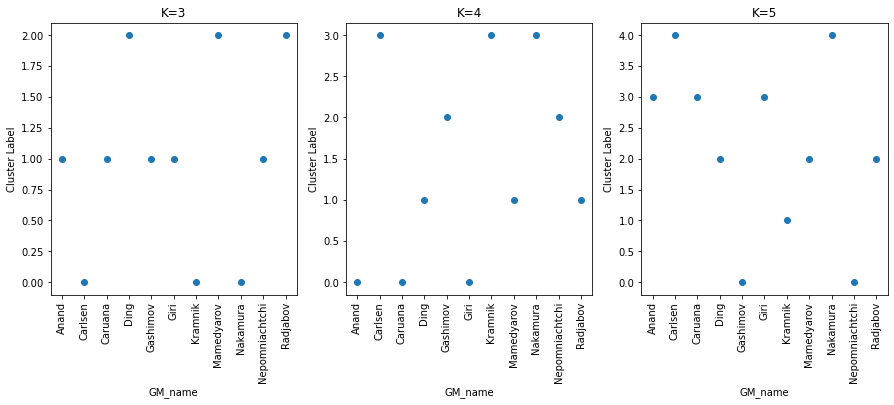

In [29]:
# Initialize a list of k values for clustering
k_values = [3, 4, 5]

# Initialize an empty list to store clustering results
results = []

# Iterate over different k values
for k in k_values:
    # Create a KMeans model with 'k' clusters and a fixed random state
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(principal_components)
    results.append(kmeans.labels_)

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, k in enumerate(k_values):
    axs[i].scatter(top5_df.index, results[i])
    axs[i].set_title(f'K={k}')
    axs[i].set_xlabel('GM_name')
    axs[i].set_ylabel('Cluster Label')
    axs[i].tick_params(axis='x', labelrotation=90)
plt.show()

#### elbow method shows clear choice: 4!

In [30]:
# Create the KMeans clustering model with 4 clusters and a fixed random state
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(principal_components)

# Calculate the silhouette score
silhouette = silhouette_score(principal_components, kmeans.labels_)

# Print the silhouette score with two decimal places
print(f'Silhouette Score: {silhouette:.2f}')

Silhouette Score: 0.69


### Final result

#### Top 5 openings dataframe had better result and seperation

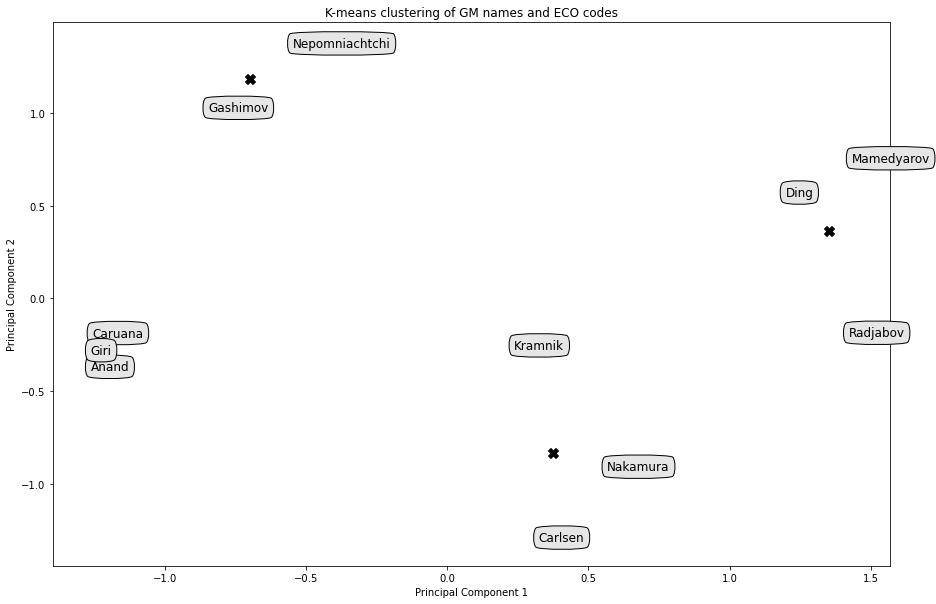

In [88]:
# Visualize the data and centroids in two-dimensional space
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', marker='X')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means clustering of GM names and ECO codes')

# Add GM names to the graph
for i, txt in enumerate(proportion.index):
    # slightly adjusted Caruana's and Anand's results, as three of them(+ Giri) were overlapping
    if txt == 'Anand' : plt.annotate(txt, (principal_components[i, 0], principal_components[i, 1] + principal_components[i, 1] * 0.3), size=12, bbox=dict(boxstyle="round4,pad=.5", fc="0.9"))
    elif txt == 'Caruana' : plt.annotate(txt, (principal_components[i, 0], principal_components[i, 1] - principal_components[i, 1] * 0.4), size=12, bbox=dict(boxstyle="round4,pad=.5", fc="0.9"))
    else: plt.annotate(txt, (principal_components[i, 0], principal_components[i, 1]), size=12, bbox=dict(boxstyle="round4,pad=.5", fc="0.9"))
    
# Set the figure size
plt.gcf().set_size_inches(15, 10)

# Display the plot
plt.show()